# Практическое использование библиотеки AutoTM

Сегодняшняя демонстрация посвящена ознакомлению с использованием библиотеки [AutoTM](https://github.com/aimclub/AutoTM). Мы узнаем об основном функционале, настраиваемых параметрах и выходных результатах библиотеки.

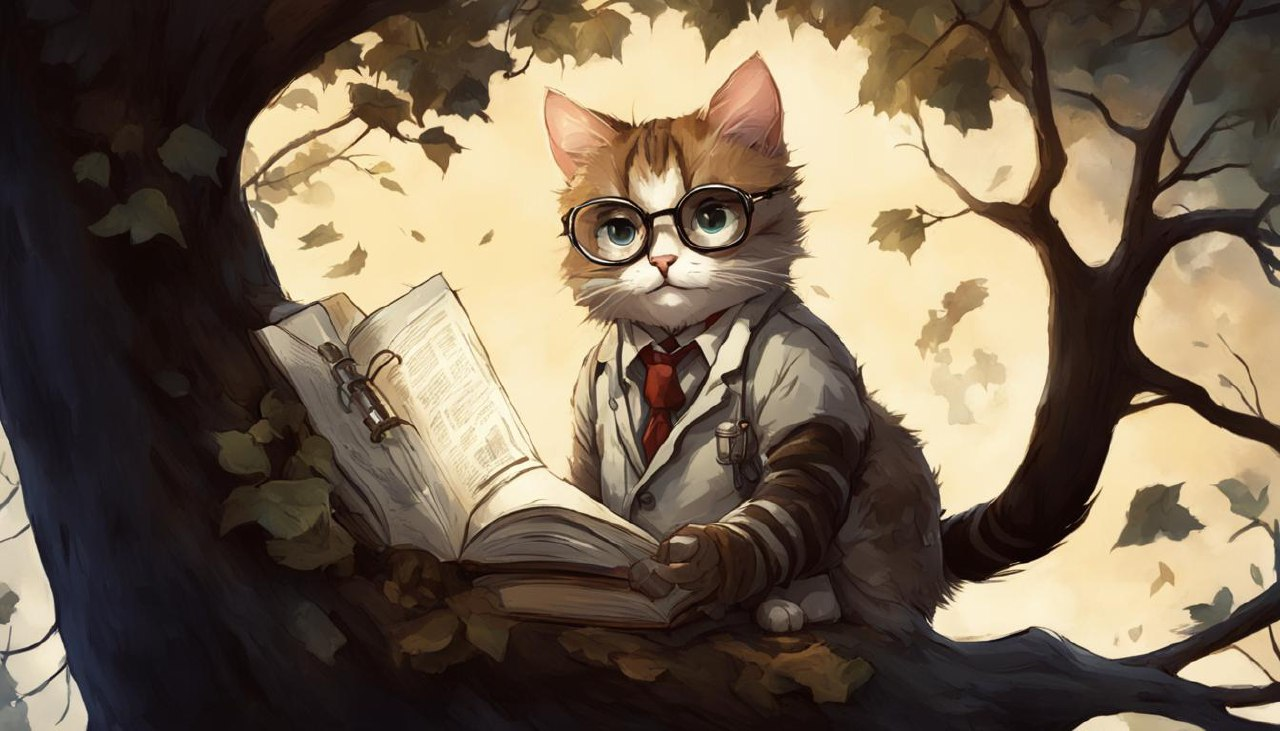

\* изображение сгенерировано моделью Кандинский 3

## Установка библиотеки

Для запуска в Colab устанавливаем виртуальное окружение с подходящей версией Python. Нам нужен Python версии 3.8 или 3.9.

In [ ]:
# !pip install --quiet virtualenv
# !virtualenv autotmenv
# !wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
# !chmod +x Miniconda3-latest-Linux-x86_64.sh
# !./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
# !conda install -q -y --prefix /usr/local python=3.9 ujson

In [ ]:
import sys
import os
sys.path.append('/usr/local/lib/python3.9/site-packages/')
os.environ['CONDA_PREFIX'] = '/usr/local/envs/autotmenv'

Библиотека autotm устанавливается достаточно просто: ```pip install autotm```.

In [ ]:
# ! pip install --quiet autotm

In [ ]:
! pip install --quiet datasets

In [ ]:
! python -m spacy download en_core_web_sm

Импортируем библиотеки, которые нам сегодня понадобятся.

In [ ]:
import time

import logging
import os
import uuid

import pandas as pd
import numpy as np
from datasets import load_dataset

from sklearn.model_selection import train_test_split

from autotm.base import AutoTM

# Тематическое моделирование

Проведем тематическое моделирование текстов с сайта Lenta.ru

In [ ]:
# df = load_dataset('zloelias/lenta-ru')  # https://huggingface.co/datasets
# text_sample = df['train']['text'][:1000]
# df = pd.DataFrame({'text': text_sample})
# df.head(2)

In [ ]:
path_to_dataset = "/root/data/sample_corpora/sample_dataset_lenta.csv"

df = pd.read_csv(path_to_dataset)
train_df, test_df = train_test_split(df, test_size=0.1)

Перейдем к обучению модели и указываем рабочую директорию в которую будут записываться артефакты, производимые во время обучения модели.


In [ ]:
working_dir_path = 'autotm_artifacts'

In [ ]:
! mkdir $working_dir_path

По умолчанию в AutoTM alg_name="ga", т.е. разработанный генетический алгоритм. Однако есть возможность использовать и байесовскую оптимизацию "bayes". У объекта AutoTM есть большое количество настраиваемых параметров, но из основных можно выделить - количество тем (topic_count), колонка для обработки (texts_column_name), количество итераций (num_iterations), путь до рабочей папки (working_dir_path). Со всеми параметрами можно ознакомииться по ссылке: https://github.com/aimclub/AutoTM/blob/main/autotm/base.py.

In [ ]:
autotm = AutoTM(
    topic_count=20,
    preprocessing_params={
        "lang": "ru",
        "min_tokens_count": 3
    },
    alg_name="ga",
    alg_params={
        "num_iterations": 2,
        "num_individuals": 10,
        "use_nelder_mead_in_mutation": False,
        "use_nelder_mead_in_crossover": False,
        "use_nelder_mead_in_selector": False,
        "train_option": "offline"
    },
    working_dir_path=working_dir_path,
    exp_dataset_name="lenta_ru"
)

Если у вас был опыт работы с библиотекой sklearn, то вам должны быть знакомы методы ```fit```, ```predict``` и их совмещенная версия ```fit_predict```.

In [ ]:
mixtures = autotm.fit_predict(train_df)

In [ ]:
print(autotm.topics['main1'])

In [ ]:
print(autotm.topics['main5'])

In [ ]:
autotm.save('model_artm')

Структура сохраненной обученной модели:
```
|model_artm
| -- artm_model
| -- | -- n_wt.bin
| -- | -- p_wt.bin
| -- | -- parameters.bin
| -- | -- parameters.json
| -- | -- scre_tracker.bin
| -- autotm_data
```



In [ ]:
fitted_model = AutoTM.load('model_artm')

In [ ]:
mixtures = fitted_model.predict(test_df) # извлекаем распределения документов по темам

In [ ]:
mixtures.head(1)

## Проведем кластеризацию полученных распределений

In [ ]:
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import plotly.graph_objects as go
from sklearn.cluster import KMeans

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

#For standardising the dat
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.manifold import TSNE

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
y = mixtures.index.values
x = mixtures.values

In [ ]:
standardized_x = StandardScaler().fit_transform(x)

In [ ]:
y_kmeans = KMeans(n_clusters=10, random_state=0).fit(standardized_x)

In [ ]:
%time
tsne = TSNE(n_components=2).fit_transform(standardized_x)

In [ ]:
plt.scatter(tsne[:, 0], tsne[:, 1],  c=y_kmeans.labels_, s=6, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Scatterplot of lenta.ru data', fontsize=24)

In [ ]:
mixtures['labels'] = y_kmeans.labels_

In [ ]:
res_df = df.join(mixtures)

In [ ]:
res_df[res_df['labels'] == 8].text.tolist()[:3]

In [ ]:
res_df[res_df['labels'] == 9].text.tolist()[:3]